# The Enron Scandal - A Fraud Detection Project Using Text Data

![enron](enron.jpg)

## Welcome

Hi, welcome to this notebook!

This is the second fraud detection project I am working on and this time, I will analyze text data in form of emails.

The goals of this project is to create a list of fraudulent terms that helps us to detect fraudulent and non-fraudulent behaviour in the emails. I will use 2 different methods: the manual one and the The natural language processing approach.

Sounds interesting, isn't it?

Let's start!

## Dataset description

For this project we will use the dataset [The Enron Email Dataset](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset) from Kaggle.

The Enron scandal was an accounting scam made by the Enron Corporation, an American energy company based in Texas. 

The Enron company was the result of merging two companies: Houston Natural Gas e InterNorth in 1985. Years later, a management team without scruples was able to hide a millions of usd dollars debt from failed deals and projects by using bad accounting practices.

Enron shareholders submitted a lawsuit for more than 40 millions of usd. after the company's share price went from 90.75usd per share to 1usd. in less than a year. 

The company Dynegy, another company from the sector, tried to purchase Enron's assets at a very low price, howerver, the deal was not sucsuccessful and, at the end of 2001, Enron filed for bankruptcy.

The Enron case is one of the bigest corporate bankruptcy in U.S. history.(for more info about the Enron Scandal:[The Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal#Further_reading)).

This dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. 



## Important libraries

In [39]:
# pandas & numpy:
import numpy as np
import pandas as pd

# visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

# tokenization:
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
import string

# gensim:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
import pyLDAvis.gensim_models

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# scikit-learn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML

#keras:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #We use this because some text are shorter than others. All text should have the same number of words

## Loading & understanding our data

In [2]:
df=pd.read_csv('Data/emails_cleaned.csv')

# With "pd.set_option('display.max_columns', None)" we see all the columns of the dataset.
pd.set_option('display.max_columns', None)
df.head()


,file,message,content,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,has_other_content,if_forwarded
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,<18782981.1075855378110.JavaMail.evans@thyme,"Mon, 14 May 2001 16:39:00 -0700 (PDT",phillip.allen@enron.co,tim.belden@enron.co,NaN,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Phillip K Alle,Tim Belden <Tim Belden/Enron@EnronXGate,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-,pallen (Non-Privileged).pst,False,False
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,<15464986.1075855378456.JavaMail.evans@thyme,"Fri, 4 May 2001 13:51:00 -0700 (PDT",phillip.allen@enron.co,john.lavorato@enron.co,Re,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Phillip K Alle,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-,pallen (Non-Privileged).pst,False,False
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,<24216240.1075855687451.JavaMail.evans@thyme,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT",phillip.allen@enron.co,leah.arsdall@enron.co,Re: tes,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Phillip K Alle,Leah Van Arsdal,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mai,Allen-,pallen.nsf,False,False
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",<13505866.1075863688222.JavaMail.evans@thyme,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT",phillip.allen@enron.co,randall.gay@enron.co,NaN,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Phillip K Alle,Randall L Ga,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mai,Allen-,pallen.nsf,False,False
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,<30922949.1075863688243.JavaMail.evans@thyme,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT",phillip.allen@enron.co,greg.piper@enron.co,Re: Hell,NaN,1.0,text/plain; charset=us-asci,7bi,NaN,Phillip K Alle,Greg Pipe,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mai,Allen-,pallen.nsf,False,False


In [3]:
# Dataset cleaning function:

def clean_data(df):
    
    df=df.drop(columns=['file', 'message', 'Cc', 'Mime-Version', 'Content-Type','Content-Transfer-Encoding','Date',
                        'Bcc', 'X-From', 'X-To', 'X-cc', 'X-bcc','X-Folder', 'X-Origin', 'X-FileName', 'has_other_content', 'if_forwarded'])
    df.columns=[e.lower().replace(' ', '_') for e in df.columns]
    
    return df

In [4]:
# This is how the dataset looks like after the cleaning process. 

df=clean_data(df)
df

,content,message-id,from,to,subject
0,Here is our forecast\n\n,<18782981.1075855378110.JavaMail.evans@thyme,phillip.allen@enron.co,tim.belden@enron.co,NaN
1,Traveling to have a business meeting takes the...,<15464986.1075855378456.JavaMail.evans@thyme,phillip.allen@enron.co,john.lavorato@enron.co,Re
2,test successful. way to go!!!,<24216240.1075855687451.JavaMail.evans@thyme,phillip.allen@enron.co,leah.arsdall@enron.co,Re: tes
3,"Randy,\n\n Can you send me a schedule of the s...",<13505866.1075863688222.JavaMail.evans@thyme,phillip.allen@enron.co,randall.gay@enron.co,NaN
4,Let's shoot for Tuesday at 11:45.,<30922949.1075863688243.JavaMail.evans@thyme,phillip.allen@enron.co,greg.piper@enron.co,Re: Hell
...,...,...,...,...,...
517392,This is a trade with OIL-SPEC-HEDGE-NG (John L...,<26807948.1075842029936.JavaMail.evans@thyme,john.zufferli@enron.co,kori.loibl@enron.co,Trade with John Lavorat
517393,Some of my position is with the Alberta Term b...,<25835861.1075842029959.JavaMail.evans@thyme,john.zufferli@enron.co,john.lavorato@enron.co,Gas Hedge
517394,2\n\n -----Original Message-----\nFrom: \tDouc...,<28979867.1075842029988.JavaMail.evans@thyme,john.zufferli@enron.co,dawn.doucet@enron.co,RE: CONFIDENTIA
517395,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,<22052556.1075842030013.JavaMail.evans@thyme,john.zufferli@enron.co,jeanie.slone@enron.co,Calgary Analyst/Associat


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517397 entries, 0 to 517396
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   content     491133 non-null  object
 1   message-id  517397 non-null  object
 2   from        517397 non-null  object
 3   to          495552 non-null  object
 4   subject     498118 non-null  object
dtypes: object(5)
memory usage: 19.7+ MB


We see that all the variables have the correct data type. We can also see that there are some missing data in the dataset. 

In [6]:
# Dropping the missing data from the dataset:

df=df.dropna().reset_index(drop=True)
df

,content,message-id,from,to,subject
0,Traveling to have a business meeting takes the...,<15464986.1075855378456.JavaMail.evans@thyme,phillip.allen@enron.co,john.lavorato@enron.co,Re
1,test successful. way to go!!!,<24216240.1075855687451.JavaMail.evans@thyme,phillip.allen@enron.co,leah.arsdall@enron.co,Re: tes
2,Let's shoot for Tuesday at 11:45.,<30922949.1075863688243.JavaMail.evans@thyme,phillip.allen@enron.co,greg.piper@enron.co,Re: Hell
3,"Greg,\n\n How about either next Tuesday or Thu...",<30965995.1075863688265.JavaMail.evans@thyme,phillip.allen@enron.co,greg.piper@enron.co,Re: Hell
4,any morning between 10 and 11:30,<17189699.1075863688308.JavaMail.evans@thyme,phillip.allen@enron.co,joyce.teixeira@enron.co,Re: PRC review - phone call
...,...,...,...,...,...
451600,This is a trade with OIL-SPEC-HEDGE-NG (John L...,<26807948.1075842029936.JavaMail.evans@thyme,john.zufferli@enron.co,kori.loibl@enron.co,Trade with John Lavorat
451601,Some of my position is with the Alberta Term b...,<25835861.1075842029959.JavaMail.evans@thyme,john.zufferli@enron.co,john.lavorato@enron.co,Gas Hedge
451602,2\n\n -----Original Message-----\nFrom: \tDouc...,<28979867.1075842029988.JavaMail.evans@thyme,john.zufferli@enron.co,dawn.doucet@enron.co,RE: CONFIDENTIA
451603,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,<22052556.1075842030013.JavaMail.evans@thyme,john.zufferli@enron.co,jeanie.slone@enron.co,Calgary Analyst/Associat


In [7]:
# There are 2 text variables in the model: subject and content.  
# we want to join all text data in one single column, therefore we will create a new column called "completed_text".

df["completed_text"]=df["subject"]+' '+df["content"]

In [8]:
# Let's see how looks the first element of the new column "completed_text"

df['completed_text'][0]

"Re Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"

## Text Cleaning

As in the numerical databases, cleaning data in text analysis is a very important part of the process. 

In order to clean our text data we need to follow these steps:
    <ol>
  <li>Remove all Stopwords</li>
  <li>Lemanize your words</li>
  <li>Stem your words</li>
  <li>Tokenization</li>
</ol>

In [9]:
# Getting stopwords for English:

stop_words = set(stopwords.words('english')) 


In [10]:
# Adding additional stop words from nltk. Since we are working with emails we will include words like: from, to,...

stop_words.update(('from','to','cc','http', 're', 'www', 'com','subject','sent','email','u','ok','thanks','please','ect'))

In [11]:
# Define punctuations to exclude and lemmatizer:

exclude = set(string.punctuation)

In [12]:
# Creating text data cleaning function:

def clean(text,stop_words):
    stop_words = set(stopwords.words('english'))
    stop_words.update(('from','to','cc','http', 're', 'www', 'com','subject','sent','email','u','ok','thanks','please','ect','dt','pm'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop_words) and (not i.isdigit()) and len(i)>3)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [13]:
# Since the dataset is too big to work with, we will choose ramdomly a sample of 1200 rows. 

sample_df=df.sample(n=1200,random_state=42)
sample_df.head()

,content,message-id,from,to,subject,completed_text
253451,We have had a problem arise today with some de...,<30302813.1075858267962.JavaMail.evans@thyme,phillip.love@enron.co,"darron.giron@enron.com, kam.keiser@enron.com, ...",Originator deal,Originator deal We have had a problem arise to...
346965,It is imperative that the evening person make ...,<5854904.1075860755228.JavaMail.evans@thyme,john.buchanan@enron.co,"larry.berger@enron.com, michael.bodnar@enron.c...",Demarc Number,Demarc Number It is imperative that the evenin...
301595,Attached is a redlined version of the agreemen...,<25425985.1075842595165.JavaMail.evans@thyme,gerald.nemec@enron.co,"lmarlatt@br-inc.com, choekenga@br-inc.co",Capacity Allocation Revision,Capacity Allocation Revision Attached is a red...
41100,Not yet. Michelle\n,<8704059.1075862047799.JavaMail.evans@thyme,michelle.cash@enron.co,lizzette.palmer@enron.co,RE: Bottchlet,RE: Bottchlet Not yet. Michelle\n
420199,I have asked that Hong Kong be removed from th...,<18067535.1075860032298.JavaMail.evans@thyme,david.forster@enron.co,"mark.taylor@enron.com, david.minns@enron.com, ...",Re: Hong Kong Weather Product,Re: Hong Kong Weather Product I have asked tha...


In [15]:
# Clean the emails in sample_df

text_clean=[]
for text in sample_df['completed_text']:
    text_clean.append(clean(text, stop_words).split())    


In [16]:
# Apply the function to the dataframe:

sample_df['clean_text'] = text_clean

In [17]:
# Now we can compare the original column "completed_text" vs the column "clean_text" using the row 41100 from sample_df
# Completed_text:

sample_df['completed_text'][41100]

'RE: Bottchlet Not yet. Michelle\n'

In [18]:
# clean_text:

print(sample_df['clean_text'][41100])

['bottchlet', 'michelle']


In [19]:
# Creating a new column named clean_joined where we join the words into a string.

sample_df['clean_joined'] = sample_df['clean_text'].apply(lambda x: " ".join(x))

In [20]:
# Let's see how the text looks like after the cleaning process.

sample_df['clean_joined'][41100]

'bottchlet michelle'

## Fraudulent flags

Now that the dataset is cleaned, we can get the fraudulent terms that will help us to create the fraudulent flags we will use to classifier the emails from the dataset. 

We will use 2 different approaches:

 <ol>
  <li>Manual method</li>
  <li>Machine learning</li>
</ol>


### Manual approach

In [21]:
# In order to use the manual approach knowledge field is key as the analysts needs to know wery well what they are looking for in the emails. 
# For example, we know that Enron employees activaley participated in the fraud by keeping the stock price manually high. 
# We can create a list of fraudulent terms that helps us to find the emails with reference to the word "stock".

fraud_list=['stock','enron stock','sell stock','bonus','wall street','the market','down jones','board','bourse','investment','weak finantials','accounting','enron stock price']

# Now we filter the column "completed text" using the list "fraud_list".


filtered_emails = sample_df.loc[sample_df['clean_joined'].str.contains('|'.join(fraud_list), na=False)]


In [22]:
# "filtered_emails" represents the emails with fraudulent terminology. 
# We will create a new column named fraud in the dataframe. 
# The new column will have 2 values: 0: non-fraud ; 1: fraud

sample_df['fraud'] = np.where((sample_df['clean_joined'].str.contains('|'.join(fraud_list)) == True), 1, 0)
        
sample_df.head()    

,content,message-id,from,to,subject,completed_text,clean_text,clean_joined,fraud
253451,We have had a problem arise today with some de...,<30302813.1075858267962.JavaMail.evans@thyme,phillip.love@enron.co,"darron.giron@enron.com, kam.keiser@enron.com, ...",Originator deal,Originator deal We have had a problem arise to...,"[originator, deal, problem, arise, today, deal...",originator deal problem arise today deal booke...,0
346965,It is imperative that the evening person make ...,<5854904.1075860755228.JavaMail.evans@thyme,john.buchanan@enron.co,"larry.berger@enron.com, michael.bodnar@enron.c...",Demarc Number,Demarc Number It is imperative that the evenin...,"[demarc, number, imperative, evening, person, ...",demarc number imperative evening person make s...,0
301595,Attached is a redlined version of the agreemen...,<25425985.1075842595165.JavaMail.evans@thyme,gerald.nemec@enron.co,"lmarlatt@br-inc.com, choekenga@br-inc.co",Capacity Allocation Revision,Capacity Allocation Revision Attached is a red...,"[capacity, allocation, revision, attached, red...",capacity allocation revision attached redlined...,0
41100,Not yet. Michelle\n,<8704059.1075862047799.JavaMail.evans@thyme,michelle.cash@enron.co,lizzette.palmer@enron.co,RE: Bottchlet,RE: Bottchlet Not yet. Michelle\n,"[bottchlet, michelle]",bottchlet michelle,0
420199,I have asked that Hong Kong be removed from th...,<18067535.1075860032298.JavaMail.evans@thyme,david.forster@enron.co,"mark.taylor@enron.com, david.minns@enron.com, ...",Re: Hong Kong Weather Product,Re: Hong Kong Weather Product I have asked tha...,"[hong, kong, weather, product, asked, hong, ko...",hong kong weather product asked hong kong remo...,1


In [23]:

count = sample_df['fraud'].value_counts()
print(count)

0    1114
1      86
Name: fraud, dtype: int64


We get our first results! We have been able to detect 86 of 1114 emails with fraudulent terminology. 

#### Visual represetation

Visual represetation can be a very powerful tool in text analysis. 

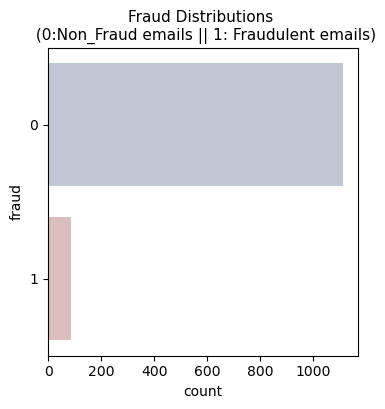

In [24]:
# Count plot to see fraudulent and non-fraudulent emails

plt.figure(figsize = (4, 4))
sns.countplot(y = "fraud", data = sample_df,palette='vlag')
plt.title('Fraud Distributions \n (0:Non_Fraud emails || 1: Fraudulent emails)', fontsize=11)
plt.show()

Another interesting visualization for text analysis is WordCloud. 
This library visualizes data in the form of text where the font size represents the frequency / importance of the word in the text.

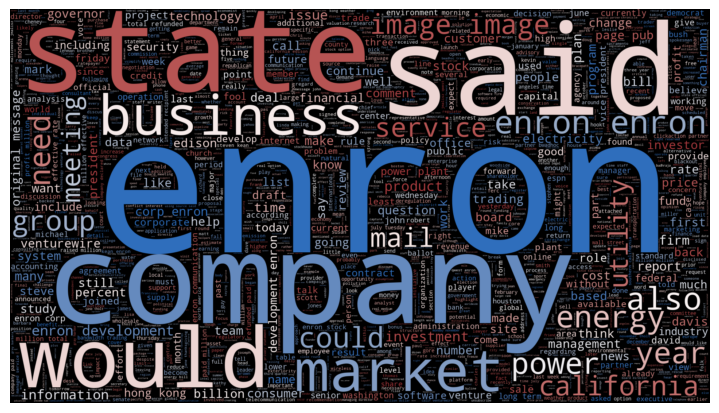

In [25]:
# plot the word cloud for text that is considered "fraud"

plt.figure(figsize = (7,7)) 
wc = WordCloud(max_words = 2000 , width = 1920 , height = 1080 ,colormap='vlag', stopwords = stop_words).generate(" ".join(sample_df[sample_df.fraud == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

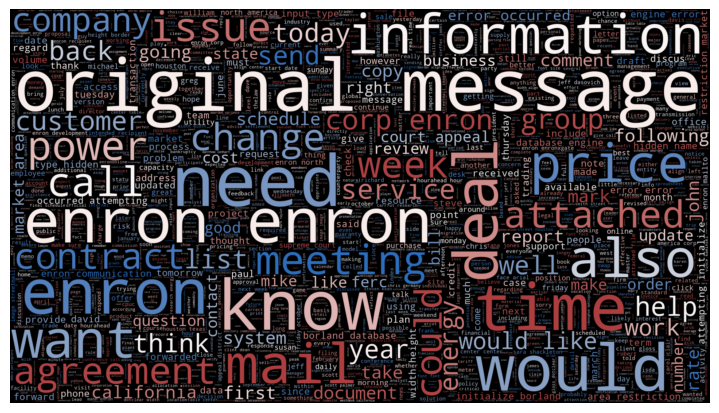

In [26]:
# plot the word cloud for text that is considered "non-fraud"
plt.figure(figsize = (7,7)) 
wc = WordCloud(max_words = 2000 , width = 1920 , height = 1080 ,colormap='vlag', stopwords = stop_words).generate(" ".join(sample_df[sample_df.fraud == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Latent Dirichlet Allocation (LDA)- The natural language processing approach. 

"LDA is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. The LDA is an example of a topic model. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics".([LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)). 

In order to apply LDA we need to follow this steps:

 <ol>
  <li>Clean the text data</li>
  <li>Create a bag of words with dictionary and corpus</li>
  <li>Fed dictionary and corpus into the LDA model</li>
  
</ol>




In [28]:
# Define the dictionary. 
# The dictionary contains the number of times a word appears for each word. 

dictionary = corpora.Dictionary(text_clean)


In [29]:
# Filter non frequent words

# This formula filters the words that appear in less than 10 emails and keep the 50000 most frequent words.

dictionary.filter_extremes(no_below=10, keep_n=50000)

In [30]:
# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]


In [31]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15,random_state=42)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.016*"enron" + 0.011*"market" + 0.010*"deal" + 0.008*"would" + 0.008*"need"')
(1, '0.020*"image" + 0.015*"center" + 0.014*"enron" + 0.012*"name" + 0.011*"company"')
(2, '0.016*"power" + 0.014*"state" + 0.012*"would" + 0.011*"error" + 0.011*"california"')
(3, '0.106*"enron" + 0.015*"message" + 0.014*"original" + 0.011*"court" + 0.011*"corp"')


#### Visual representation

In order to fully understand the topics of our model we need to visualize. Lda_display is a great library from gensim that we can use for this purpose.


In [32]:

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus,dictionary, sort_topics=False)

pyLDAvis.display(lda_display)


In [40]:
# Note: It is necessary to run the notebook in your computer in order to see the visualization, but we can save it as a html file and insert the html file in the jupyter notebook. .

# save the visualization:
pyLDAvis.save_html(lda_display, 'lda.html')

# insert the html file in the jupyter notebook. 
HTML(filename='lda.html')

Each bubble represents a different topic. The biggest the bubble the most important/ relevant the topic is in the dataset. 
After analyzing the clusters, we can see that cluster number 2 has terms related to stocks

In [41]:
# Now we have to assign the topics to the original data:

def get_topic(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):  
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic              
                wp = ldamodel.show_topic(topic_num)                
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]),ignore_index=True)  
        
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df


In [42]:
# Add original text to topic details in a dataframe

contents = pd.DataFrame({'Original text': text_clean})
topic_df = pd.concat([get_topic(ldamodel, corpus), contents], axis=1)


In [43]:
# Create flag for text highest associated with topic 2

topic_df['fraud_lda_model'] = np.where((topic_df['Dominant_Topic'] == 2.0), 1, 0)


In [44]:
count = topic_df['fraud_lda_model'].value_counts()
print(count)

0    940
1    260
Name: fraud_lda_model, dtype: int64


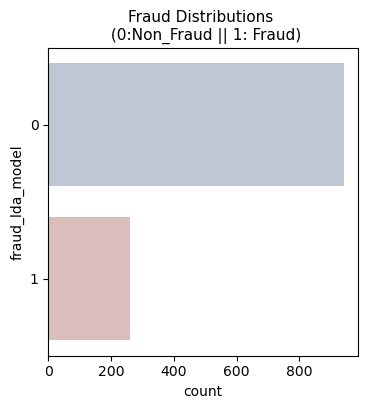

In [38]:
#Plot the count plot for fraudulent and no fraudulent emails
plt.figure(figsize = (4, 4))
sns.countplot(y = "fraud_lda_model", data = topic_df,palette='vlag')
plt.title('Fraud Distributions \n (0:Non_Fraud || 1: Fraud)', fontsize=11)
plt.show()

## Conclusions

After completing the text analysis of the dataset, we obtained the following insights:

<ul>
  <li>First item</li>
  <li>Second item</li>
  <li>Third item</li>
  <li>Fourth item</li>
</ul>



If you have made it this far, thank you! Feel free to drop me a message with your feedback. Also, I would appreciate if you vote for it. 


## References

<ul>
  <li>[Course:Fraud Detection in Python by DataCamp](https://app.datacamp.com/learn/courses/fraud-detection-in-python)</li>
  <li>[The Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal) </li>
  <li>[LDA](https://es.wikipedia.org/wiki/Latent_Dirichlet_Allocation) </li>
  
</ul>